In [64]:
import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"       # defrags GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"      # don't grab all VRAM up front
import sys
import jax
jax.config.update("jax_enable_x64", True)

batch_size = 128
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
num_cores = jax.local_device_count()

import jax.interpreters.xla as xla
import jax.core

if not hasattr(xla, "pytype_aval_mappings"):
    xla.pytype_aval_mappings = jax.core.pytype_aval_mappings

import sys
sys.path.append("../../../sampler-comparison")
sys.path.append("../../../sampler-evaluation")
sys.path.append("../../../../src/inference-gym/spinoffs/inference_gym")
sys.path.append("../../../../blackjax")
import os
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../../../blackjax')
sys.path.append('../sampler-comparison')
sys.path.append('../../../sampler-evaluation')
sys.path.append('../../../')
sys.path.append("../../../../src/inference-gym/spinoffs/inference_gym")
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sampler_evaluation
from sampler_comparison.samplers import samplers
import seaborn as sns
from functools import partial
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error
from sampler_comparison.samplers.hamiltonianmontecarlo.hmc import adjusted_hmc
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc


from sampler_comparison.samplers.general import make_log_density_fn
import blackjax
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error

import numpy as np
import jax
import jax.numpy as jnp
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import blackjax
from blackjax.util import run_inference_algorithm
import blackjax

from blackjax.adaptation.unadjusted_alba import unadjusted_alba
from blackjax.adaptation.unadjusted_step_size import robnik_step_size_tuning
from blackjax.adaptation.unadjusted_alba import unadjusted_alba
import math
from blackjax.mcmc.adjusted_mclmc_dynamic import make_random_trajectory_length_fn
from functools import partial
from blackjax.adaptation.step_size import bisection_monotonic_fn
from blackjax.util import thin_algorithm
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc_no_tuning
from results.run_benchmarks import lookup_results
from sampler_comparison.util import calls_per_integrator_step


def compose(f, g):
    return lambda x: f(g(x))


def blackjax_las(model, num_chains, key, ndims, num_adjusted_steps, diagonal_preconditioning=True, target_acceptance_rate=0.8, target_eevpd=5e-1, adjusted_integrator_type="velocity_verlet", unadjusted_integrator_type="velocity_verlet"):

    integrator_map = {
                "velocity_verlet": blackjax.mcmc.integrators.isokinetic_velocity_verlet,
                "mclachlan": blackjax.mcmc.integrators.isokinetic_mclachlan,
                "omelyan": blackjax.mcmc.integrators.isokinetic_omelyan,
            }

    init_key, tune_key, unadjusted_key, adjusted_key = jax.random.split(key, 4)
    initial_position = jax.random.normal(init_key, (ndims,))

    logdensity_fn = make_log_density_fn(model)
    ### Phase 1: unadjusted ###

        
    # burn-in and adaptation
    num_alba_steps = 10000
    warmup = unadjusted_alba(
        # algorithm=blackjax.mclmc, 
        mcmc_kernel=blackjax.mclmc.build_kernel(integrator_map[unadjusted_integrator_type]),
        init=blackjax.mclmc.init,
        logdensity_fn=logdensity_fn, 
        target_eevpd=target_eevpd, 
        v=1, 
        num_alba_steps=num_alba_steps,
        preconditioning=diagonal_preconditioning,
        alba_factor=0.4,
        )

    (blackjax_state_after_tuning, blackjax_mclmc_sampler_params), adaptation_info = warmup.run(tune_key, initial_position, 20000)
    # blackjax_mclmc_sampler_params['step_size'] = 2.2048060908970006* jnp.sqrt(ndims)
    step_size_after_unadjusted_tuning = blackjax_mclmc_sampler_params['step_size']



    # sampling
    ess_per_sample = blackjax_mclmc_sampler_params['ESS']
    print(f"ESS per sample according to tuning: {ess_per_sample}")

    num_steps = math.ceil(num_chains // ess_per_sample)

    alg = blackjax.mclmc(
            logdensity_fn=logdensity_fn,
            L=blackjax_mclmc_sampler_params['L'],
            step_size=blackjax_mclmc_sampler_params['step_size'],
            inverse_mass_matrix=blackjax_mclmc_sampler_params['inverse_mass_matrix'],
            integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        )

    thinning_rate = math.ceil(1/ess_per_sample)

    jax.debug.print("thinning_rate {x}", x=thinning_rate)

    alg = thin_algorithm(
                    alg,
                    thinning=thinning_rate,
                    info_transform=lambda info: jax.tree.map(jnp.mean, info),
                    )

    


    final_output, (history) = run_inference_algorithm(
            rng_key=unadjusted_key,
            initial_state=blackjax_state_after_tuning,
            inference_algorithm=alg,
            num_steps=num_chains,
            # num_steps=num_chains*thinning_rate,
            transform=lambda a, b: a,
            progress_bar=False,
        )
    samples = history.position # [::thinning_rate]
    # jax.debug.print("shape of samples {x}", x=samples.shape)

    # adjusted_num_grads_per_step = 2 * num_adjusted_steps
    # subsamples = samples[::thinning_rate]
    
    unadjusted_num_grads_per_step = calls_per_integrator_step(unadjusted_integrator_type) * thinning_rate
    subsamples = samples
    # jax.debug.print("shape of subsamples {x}", x=subsamples.shape)
    # raise Exception("stop here")

    integration_steps_fn = make_random_trajectory_length_fn(True)

    adjusted_integrator = integrator_map[adjusted_integrator_type]



    def make_mams_step(key):
        def mams_step(inp):

            step_size, positions, info, step_size_adaptation_state = inp
            # jax.debug.print("step_size {step_size}", step_size=(step_size, blackjax_mclmc_sampler_params['L']))
            num_steps_per_traj = 4 #blackjax_mclmc_sampler_params['L'] / step_size
            
            jax.debug.print("num_steps_per_traj using L {x}", x=(blackjax_mclmc_sampler_params['L']/ step_size, step_size, blackjax_mclmc_sampler_params['L'], blackjax_mclmc_sampler_params['step_size']))
            
            
            keys = jax.random.split(key, positions.shape[0])
            alg = blackjax.adjusted_mclmc_dynamic(
                    logdensity_fn=logdensity_fn,
                    step_size=step_size,
                    integration_steps_fn=integration_steps_fn(num_steps_per_traj),
                    integrator=adjusted_integrator,
                    inverse_mass_matrix=blackjax_mclmc_sampler_params['inverse_mass_matrix'],
                    # inverse_mass_matrix=(np.ones(positions.shape[1])),
                    L_proposal_factor=jnp.inf,
                )
            

            def step_fn(pos_key):
                pos, key = pos_key
                init_key, run_key = jax.random.split(key, 2)
                state, info = alg.step(
                    rng_key=run_key,
                    state=blackjax.adjusted_mclmc_dynamic.init(pos, logdensity_fn, init_key),
                )
                return state, info
            
            new_states, infos = jax.lax.map(step_fn, xs=(positions,keys))
            # jax.debug.print("num_integration_steps {x}", x=infos.num_integration_steps)
            return (step_size, new_states.position, infos, step_size_adaptation_state)
            # return (step_size, positions, infos, step_size_adaptation_state)

        return mams_step
        
    jax.debug.print("target_acceptance_rate {x}", x=target_acceptance_rate)
    epsadap_update = bisection_monotonic_fn(target_acceptance_rate)
    step_size_adaptation_state_initial = (jnp.array([-jnp.inf, jnp.inf]), False)
        
    def tuning_step(inp):

        old_step_size, old_positions, old_infos, step_size_adaptation_state = inp
        acc_rate = old_infos.acceptance_rate.mean()
        max_index = old_infos.acceptance_rate.argmax()
        
        jax.debug.print("acc_rate {x}", x=old_infos.acceptance_rate.mean())
        jax.debug.print("energy {x}", x=old_infos.energy[max_index])
        jax.debug.print("energy old {x}", x=old_infos.old_energy[max_index])
        jax.debug.print("kinetic energy {x}", x=old_infos.kinetic_energy[max_index])
        jax.debug.print("delta energy {x}", x=old_infos.delta_energy[max_index])
        jax.debug.print("divergent{x}", x=old_infos.is_divergent[max_index])
        jax.debug.print("pos {x}" , x=old_positions[max_index, 0])

        
        
        step_size_adaptation_state, new_step_size = epsadap_update(
            step_size_adaptation_state,
            old_step_size,
            acc_rate,
        )

        jax.debug.print("adaptation_state {x}", x=step_size_adaptation_state)

        # new_step_size = 0.0
        
        return (new_step_size, old_positions, old_infos, step_size_adaptation_state)

    def step_fn(inp, key):
        results =  make_mams_step(key)(inp)
        tuned_params = tuning_step(results)
        return tuned_params, tuned_params
    
    initial_adjusted_key, adjusted_key = jax.random.split(adjusted_key, 2)

    # just doing this to generate infos, which is silly
    _, _, infos, _ = make_mams_step(initial_adjusted_key)((blackjax_mclmc_sampler_params['step_size'], subsamples, None, step_size_adaptation_state_initial))

    positions = subsamples
    # step_size = blackjax_mclmc_sampler_params['step_size'] / 5

    EEVPD_a= (4/ndims) * (jax.scipy.special.ndtri(target_acceptance_rate / 2))**2
    step_size_adjusted = blackjax_mclmc_sampler_params['step_size'] * (EEVPD_a / target_eevpd)**(1/6)

    _, (step_sizes, positions, infos, step_size_adaptation_state) = jax.lax.scan(step_fn, (step_size_adjusted, subsamples, infos, step_size_adaptation_state_initial), jax.random.split(adjusted_key, num_adjusted_steps))
    # add the first step size to the list
    jax.debug.print("step_sizes {x}", x=step_sizes)
    step_sizes = jnp.concatenate([jnp.array([step_size_adjusted]), step_sizes])

    adjusted_num_grads_per_integrator_step = calls_per_integrator_step(adjusted_integrator_type) 

    # print(infos.num_integration_steps.shape, "num_integration_steps")
    adjusted_num_grads_per_step = infos.num_integration_steps.sum(axis=1)
    # print(adjusted_num_grads_per_step.shape, "adjusted_num_grads_per_step")

    return samples, positions, infos, num_steps, step_size_adaptation_state, step_sizes, unadjusted_num_grads_per_step, adjusted_num_grads_per_step, step_size_after_unadjusted_tuning, adjusted_num_grads_per_integrator_step


def las(num_adjusted_steps, num_chains, diagonal_preconditioning=True, target_acceptance_rate=0.8, target_eevpd=5e-4, adjusted_integrator_type="velocity_verlet", unadjusted_integrator_type="velocity_verlet"):

    def s(model, key):
        unadjusted_position, adjusted_position, infos, num_steps_unadjusted, step_size_adaptation_state, step_sizes, unadjusted_num_grads_per_step, adjusted_num_grads_per_step, step_size_after_unadjusted_tuning,adjusted_num_grads_per_integrator_step = blackjax_las(
            model=model,
            key=key,
            ndims=model.ndims,
            num_adjusted_steps=num_adjusted_steps,
            num_chains=num_chains,
            diagonal_preconditioning=diagonal_preconditioning,
            target_acceptance_rate=target_acceptance_rate,
            target_eevpd=target_eevpd,
            adjusted_integrator_type=adjusted_integrator_type,
            unadjusted_integrator_type=unadjusted_integrator_type
        )
        
        return unadjusted_position, adjusted_position, infos, num_steps_unadjusted, step_sizes, unadjusted_num_grads_per_step, adjusted_num_grads_per_step, step_size_after_unadjusted_tuning,adjusted_num_grads_per_integrator_step
        
    return s


In [65]:
# model = stochastic_volatility_mams_paper
model = IllConditionedGaussian(ndims=1000, condition_number=1, eigenvalues='log')
# model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')



In [66]:
# run las on banana
# num_steps1 = 1000
num_adjusted_steps = 2
num_chains = 1000
diagonal_preconditioning = False
target_eevpd = 5e-1
print("running las")
# sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning, target_eevpd=2e-8)
sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning, target_eevpd=target_eevpd, target_acceptance_rate=0.9, adjusted_integrator_type="velocity_verlet", unadjusted_integrator_type="velocity_verlet")
unadjusted_samples, adjusted_samples, infos, num_steps_unadjusted, step_sizes, unadjusted_num_grads_per_step, adjusted_num_grads_per_step, step_size_after_unadjusted_tuning, adjusted_num_grads_per_integrator_step = sampler(model, key=jax.random.key(1))
# unadjusted_samples = sampler(model, key=jax.random.key(0))
# print(samples)
# print(samples.shape)



running las


ESS per sample according to tuning: 1.7492522363495966
thinning_rate 1
target_acceptance_rate 0.9
num_steps_per_traj using L (Array(0.22886585, dtype=float64), Array(57.0580224, dtype=float64, weak_type=True), Array(13.0586327, dtype=float64), Array(57.0580224, dtype=float64, weak_type=True))
num_steps_per_traj using L (Array(1.02172046, dtype=float64), Array(12.781023, dtype=float64), Array(13.0586327, dtype=float64), Array(57.0580224, dtype=float64))
kinetic energy 72.10458016000213
energy old 558.9898654523446
energy 485.8676323614527
pos -0.5775076238463259
divergentFalse
delta energy 1.0176529308897528
acc_rate 0.5737592077340006
adaptation_state (Array([      -inf, 2.54796149], dtype=float64), Array(False, dtype=bool))
num_steps_per_traj using L (Array(2.04344092, dtype=float64), Array(6.3905115, dtype=float64), Array(13.0586327, dtype=float64), Array(57.0580224, dtype=float64))
kinetic energy 13.163301311502028
energy old 539.2067644556514
energy 525.9956927474125
pos -0.0263769

In [67]:

unadjusted_samples = jax.vmap(model.default_event_space_bijector)(unadjusted_samples)
adjusted_samples = jax.vmap(jax.vmap(model.default_event_space_bijector))(adjusted_samples)

In [68]:
# from blackjax.diagnostics import effective_sample_size
# ess = effective_sample_size(unadjusted_samples[None, :, :])
# ess.mean()

In [69]:
adjusted_error_at_each_step = ((((adjusted_samples**2).mean(axis=1) - model.sample_transformations["square"].ground_truth_mean[None, :])**2)/(model.sample_transformations["square"].ground_truth_standard_deviation[None, :]**2)).mean(axis=-1)

# adjusted_error_at_each_step = np.concatenate([[0], adjusted_error_at_each_step])
adjusted_error_at_each_step = np.repeat(adjusted_error_at_each_step, np.ceil(infos.num_integration_steps.mean(axis=1)).astype(jnp.int32)*num_chains*adjusted_num_grads_per_integrator_step)

adjusted_acc_rate_at_each_step = np.repeat(infos.acceptance_rate.mean(axis=1), np.ceil(infos.num_integration_steps.mean(axis=1)).astype(jnp.int32)*num_chains*adjusted_num_grads_per_integrator_step)



cumulative_adjusted_error_at_each_step = np.cumsum(adjusted_error_at_each_step)/np.arange(1, adjusted_error_at_each_step.shape[0]+1)

unadjusted_error_at_each_step = get_standardized_squared_error(
    unadjusted_samples[None, :, :], 
    f=model.sample_transformations["square"].fn,
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.mean
    )[0]

unadjusted_error_at_each_step = np.repeat(unadjusted_error_at_each_step, unadjusted_num_grads_per_step)


full = np.concatenate([unadjusted_error_at_each_step, cumulative_adjusted_error_at_each_step])



In [8]:
from sampler_comparison.samplers.microcanonicalmontecarlo.adjusted import (
    adjusted_mclmc,
)

sampler = adjusted_mclmc(
    num_adjusted_tuning_steps=500,num_unadjusted_tuning_steps=1000,
    target_acc_rate=0.9,
    diagonal_preconditioning=False, integrator_type='velocity_verlet',
    return_samples=True)


mams_samples, mams_infos = sampler(
    model=model,
    key=jax.random.key(0),
    initial_position=jax.random.normal(jax.random.key(0), shape=(model.ndims,)),
    num_steps=10000
)




In [9]:
mams_infos['num_grads_per_proposal']
infos.acceptance_rate.mean(axis=1)[4].item()
unadjusted_num_grads_per_step


1

In [13]:
mams_adjusted_error_at_each_step = get_standardized_squared_error(
    mams_samples[None, :, :], 
    f=model.sample_transformations["square"].fn,
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.mean
    )[0]

mams_adjusted_error_at_each_step = np.repeat(mams_adjusted_error_at_each_step, mams_infos['num_grads_per_proposal'].astype(jnp.int32))




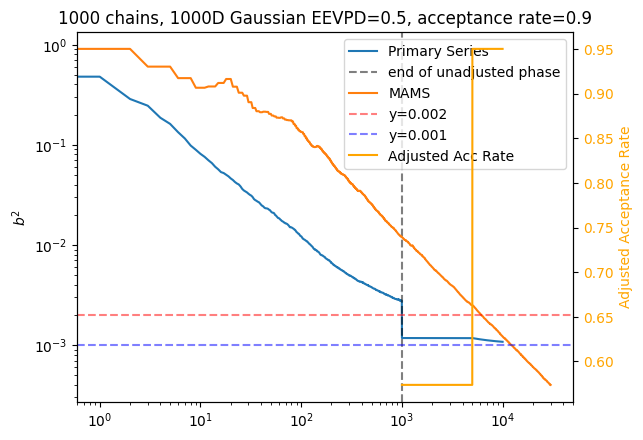

In [70]:

cutoff = 0 * unadjusted_num_grads_per_step

fig, ax1 = plt.subplots()

# Plot on primary y-axis (ax1)
l1 = ax1.plot(full[cutoff:], label='Primary Series')[0]
ax1.set_yscale('log')
ax1.set_xscale('log')
# Vertical line at the end of the unadjusted phase
ax1.axvline(x=unadjusted_error_at_each_step.shape[0] - cutoff, color='black', linestyle='--', alpha=0.5, label='end of unadjusted phase')
# Plot MAMS error on ax1
l2 = ax1.plot(mams_adjusted_error_at_each_step, label='MAMS')[0]
# Horizontal reference line
l3 = ax1.axhline(y=2/num_chains, color='red', linestyle='--', alpha=0.5, label=f'y={2/num_chains}')
l3 = ax1.axhline(y=1/num_chains, color='blue', linestyle='--', alpha=0.5, label=f'y={1/num_chains}')
ax1.set_ylabel('$b^2$')
ax1.set_title(f"{num_chains} chains, {model.ndims}D Gaussian EEVPD={target_eevpd}, acceptance rate=0.9")



# Setup secondary y-axis (ax2)
ax2 = ax1.twinx()
# only dots, not connected
ys = np.concatenate([np.zeros((unadjusted_error_at_each_step.shape[0]+1))+jnp.nan, adjusted_acc_rate_at_each_step])
l4 = ax2.plot(ys,
    
    color='orange', 
    label='Adjusted Acc Rate',

    
    )[0]

ax2.set_ylabel('Adjusted Acceptance Rate', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Combine all legend handles
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='best')

plt.show()



In [15]:
list(zip(step_sizes, infos.acceptance_rate.mean(axis=1)))
# infos.acceptance_rate.mean(axis=1)

[(Array(27.64635469, dtype=float64), Array(0.30848612, dtype=float64))]

In [52]:
# first_error = ((((adjusted_samples[0, :, :]**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2)/(model.sample_transformations["square"].ground_truth_standard_deviation**2)).mean(axis=-1)
last_unadjusted_error = ((((unadjusted_samples**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2)/(model.sample_transformations["square"].ground_truth_standard_deviation**2)).mean(axis=-1)

last_unadjusted_error


Array(0.00418431, dtype=float64)

In [21]:
# effective sample size
import sampler_evaluation
from blackjax.diagnostics import effective_sample_size
ess = effective_sample_size(unadjusted_samples[None, :, :])
ess.shape
ess.mean()
# unadjusted_samples[:, 1]

# unadjusted_samples.shape

Array(3278.57695026, dtype=float64)

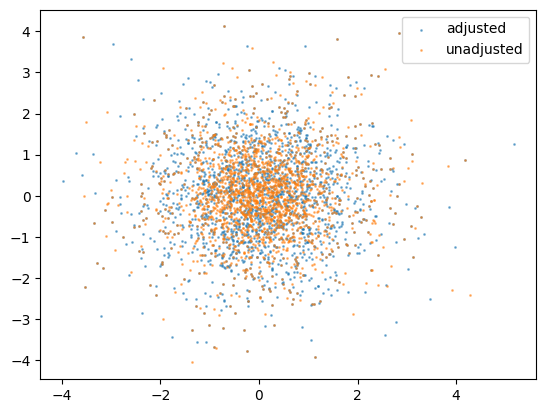

In [20]:
plt.scatter(adjusted_samples[0,:, 0], adjusted_samples[0,:, 1], alpha=0.5, label='adjusted', s=1.0, )
# plt.scatter(adjusted_samples[-1,:, 0], adjusted_samples[-1,:, 1], alpha=0.5, label='adjusted', s=1.0, )
plt.scatter(unadjusted_samples[:, 0], unadjusted_samples[:, 1], alpha=0.5, label='unadjusted', s=1.0, )
# unadjusted_samples.shape
plt.legend()

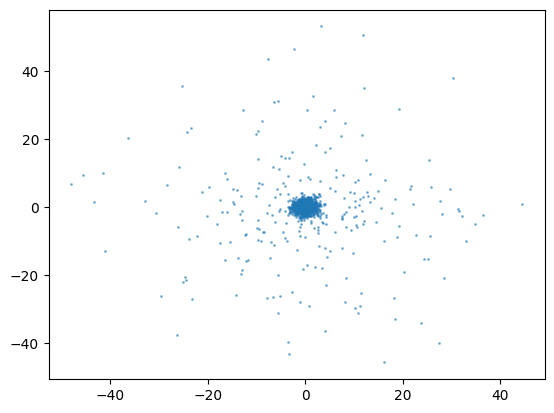

In [92]:
plt.scatter(adjusted_samples[10,:, 0], adjusted_samples[10,:, 1], alpha=0.5, label='adjusted', s=1.0, )

In [ ]:
# ((((adjusted_samples[0]**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2) / (model.sample_transformations["square"].ground_truth_standard_deviation**2)).mean()

# ((((unadjusted_samples**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2) / (model.sample_transformations["square"].ground_truth_standard_deviation**2)).mean()


# adjusted_error_at_each_step[0]

Array(0.2334355, dtype=float32)

{(0.001, 100): (np.float64(5440.0), np.int64(25000), np.int64(384)), (0.01, 100): (np.float64(5440.0), np.int64(430), np.int64(430)), (0.1, 100): (np.float64(5440.0), np.int64(464), np.int64(464)), (1.0, 100): (np.float64(5440.0), np.int64(24000), inf), (0.001, 1000): (np.float64(4110.0), np.int64(274500), np.int64(420)), (0.01, 1000): (np.float64(4110.0), np.int64(464), np.int64(464)), (0.1, 1000): (np.float64(4110.0), np.int64(512), np.int64(512)), (1.0, 1000): (np.float64(4110.0), np.int64(16000), inf), (0.001, 10000): (np.float64(1490.0), np.int64(396), np.int64(396)), (0.01, 10000): (np.float64(1490.0), np.int64(486), np.int64(486)), (0.1, 10000): (np.float64(1490.0), np.int64(518), np.int64(518)), (1.0, 10000): (np.float64(1490.0), np.int64(502), np.int64(502))}


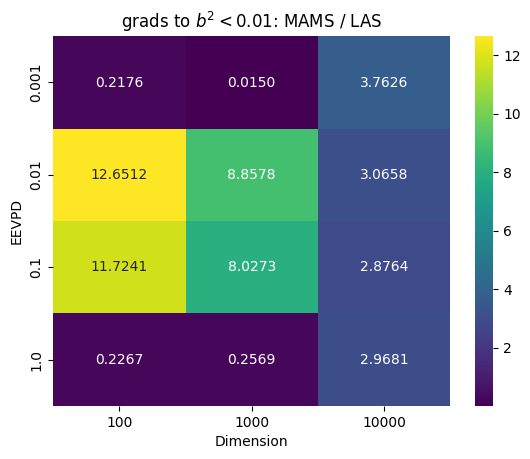

In [2]:
# make a heatmap of the full_results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
# Extract data for the heatmap

# load full_results from pickle

diagonal_preconditioning = False
full_results = pickle.load(open(f'../../full_results_new_{diagonal_preconditioning}.pkl', 'rb'))

# pretty print full_results
print(full_results)
dims = sorted(list(set([k[1] for k in full_results.keys()])))
eevpds = sorted(list(set([k[0] for k in full_results.keys()])))
# Compute the ratio for each (eevpd, dim) pair
heatmap_data = np.zeros((len(eevpds), len(dims)))
for k in full_results:
    heatmap_data[eevpds.index(k[0]), dims.index(k[1])] = full_results[k][0] / full_results[k][1]

# make df
df = pd.DataFrame(heatmap_data, index=eevpds, columns=dims)
# full_results

sns.heatmap(df, annot=True, fmt='.4f', cmap='viridis', cbar=True)
# label the axes
plt.xlabel('Dimension')
plt.ylabel('EEVPD')
plt.title('grads to $b^2<0.01$: MAMS / LAS')
plt.show()


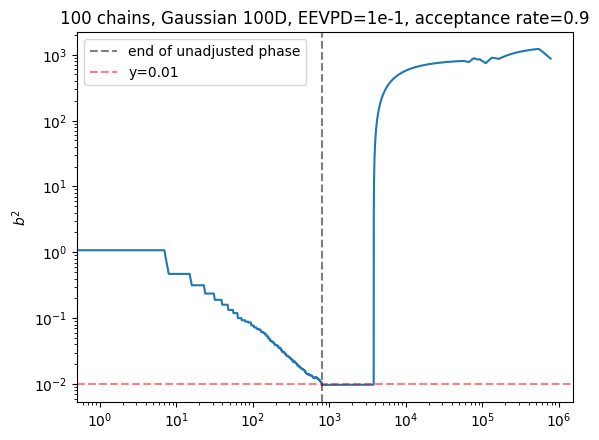

In [137]:
unadjusted_error_at_each_step.shape[0]

200

In [170]:
unadjusted_error_at_each_step[-1], adjusted_error_at_each_step[16*5000]

(Array(0.00809509, dtype=float32), Array(0.00665969, dtype=float32))

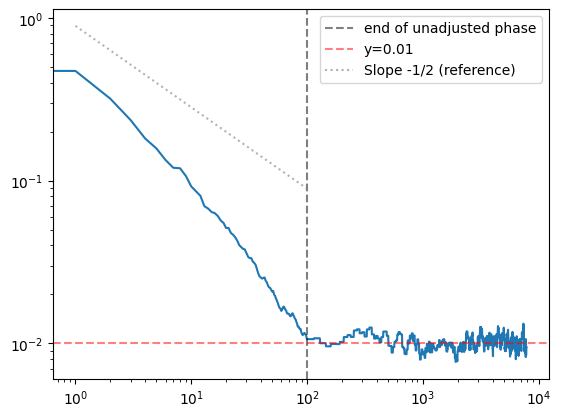

In [5]:
# effective sample size
# import sampler_evaluation
from blackjax.diagnostics import effective_sample_size
ess = effective_sample_size(unadjusted_samples[None, :, :])
ess.shape
ess.mean()

Array(672.44934, dtype=float32)

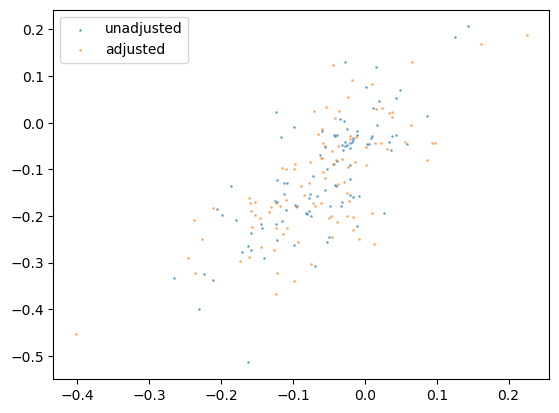

In [6]:
# unadjusted_samples[:, 1]
# unadjusted_samples.shape
# adjusted_samples.shape
plt.scatter(unadjusted_samples[::10, 0], unadjusted_samples[::10, 1], alpha=0.5, label='unadjusted', s=1.0, )
plt.scatter(adjusted_samples[-1, :, 0], adjusted_samples[-1, :, 1], alpha=0.5, label='adjusted', s=1.0, )
plt.legend()
plt.show()

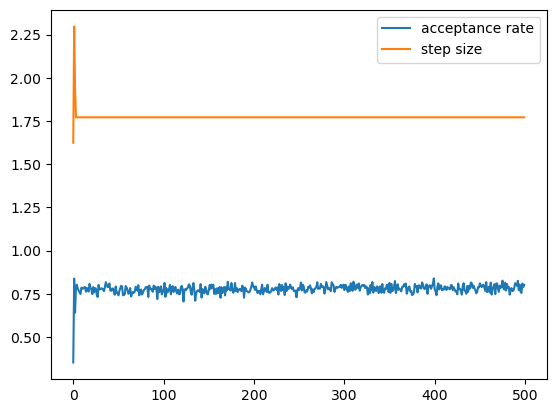

In [14]:
# print(unadjusted_samples[-1])

plt.plot(infos.acceptance_rate.mean(axis=1), label='acceptance rate')
# plt.plot(infos.num_integration_steps.mean(axis=1), label='num integration steps')
plt.plot(step_sizes, label='step size')
plt.legend()
plt.show()

In [7]:
# adjusted_error_at_each_step = ((((adjusted_samples**2) - model.sample_transformations["square"].ground_truth_mean[None, :])**2)/(model.sample_transformations["square"].ground_truth_standard_deviation[None, :]**2)).mean(axis=-1)


# adjusted_error_at_each_step_single = ((((unadjusted_samples**2).mean(axis=0) - model.sample_transformations["square"].ground_truth_mean)**2)/(model.sample_transformations["square"].ground_truth_standard_deviation**2))


fun = lambda i : ((((model.sample_transformations["square"].ground_truth_mean -  (adjusted_samples[i]**2).mean(axis=[0])))**2 ) / (model.sample_transformations["square"].ground_truth_standard_deviation**2))

adjusted_errs = jax.vmap(fun)(jnp.arange(adjusted_samples.shape[0])).max(axis=-1)


(100, 2429)

In [10]:
# adjusted_num_grads_per_step

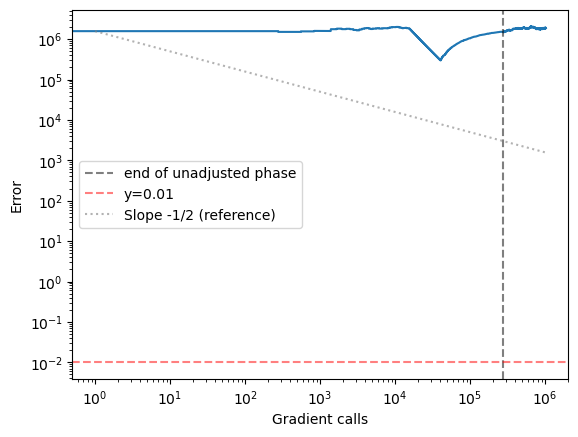

In [8]:
unadjusted_error_at_each_grad = np.repeat(unadjusted_error_at_each_step, unadjusted_num_grads_per_step)
adjusted_error_at_each_grad = np.repeat(adjusted_errs, jnp.ceil(adjusted_num_grads_per_step).astype(jnp.int32))

drop_first_n_steps = 0
# plt.plot(np.concatenate([unadjusted_error_at_each_step[drop_first_n_steps:], adjusted_errs[:]]))
plt.plot(np.concatenate([unadjusted_error_at_each_grad[drop_first_n_steps:], adjusted_error_at_each_grad[:]]))
# plt.plot(np.concatenate([unadjusted_error_at_each_grad[drop_first_n_steps:]]))

# log scale
# plt.plot(np.concatenate([adjusted_errs[:]]))
# plt.yscale('log')
# plt.plot(adjusted_errs)
# plt.plot(unadjusted_error_at_each_step)
# add a vertical line at the end of the unadjusted phase
plt.axvline(x=unadjusted_error_at_each_grad.shape[0] - drop_first_n_steps, color='black', linestyle='--', alpha=0.5, label='end of unadjusted phase')
plt.axhline(y=0.01, color='red', linestyle='--', alpha=0.5, label='y=0.01')
# plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='y=0')
plt.xlabel('Gradient calls')
# plot -1/2 lines in log space in background
# We'll plot a line with slope -1/2 in log-log space for visual reference
x_vals = np.linspace(1, unadjusted_error_at_each_grad.shape[0] + adjusted_error_at_each_grad.shape[0], 500)
y_ref = (x_vals / x_vals[0])**(-0.5) * unadjusted_error_at_each_grad[drop_first_n_steps]  # anchor at first point
plt.plot(x_vals, y_ref, color='gray', linestyle=':', alpha=0.6, label='Slope -1/2 (reference)')
plt.ylabel('Error')
plt.yscale('log')
plt.xscale('log')
plt.legend()
# plt.plot(unadjusted_error_at_each_step)
# save in sampler-comparison/sampler_comparison/experiments/results/figures
# plt.savefig(f'las_bias_{model.name}.png')
plt.show()
plt.close()
# plt.plot(adjusted_error_at_each_step)
# plt.show()
# plt.savefig(f'las_bias_adjusted_{model.name}.png')
# plt.close()

In [ ]:

sampler = partial(unadjusted_mclmc,num_tuning_steps=10000, integrator_type='mclachlan', diagonal_preconditioning=False, desired_energy_var=5e-4)

unadjusted_samples, metadata = sampler(return_samples=True)(
        model=model, 
        num_steps=100000,
        initial_position=jax.random.normal(jax.random.key(0), shape=(model.ndims,)), 
        key=jax.random.key(1))



In [12]:
# save metadata['inverse_mass_matrix'] to absolute path in storage 

# np.save('/global/cfs/cdirs/m4031/reubenh/inverse_mass_matrix.npy', metadata)
metadata['L'], metadata['step_size']

(Array(21.049892, dtype=float32),
 Array(1.2742635, dtype=float32, weak_type=True))

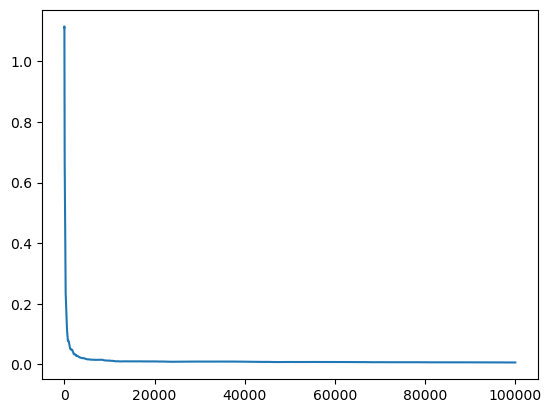

In [13]:
unadjusted_error_at_each_step = get_standardized_squared_error(
    unadjusted_samples[None, :, :], 
    f=model.sample_transformations["square"].fn,
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2,
    contract_fn=jnp.mean
    )[0]

plt.plot(unadjusted_error_at_each_step[:])
plt.show()


In [ ]:
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')
# num_steps1 = 1000
num_adjusted_steps = 100
num_chains = 200
diagonal_preconditioning = True
print("running las")
sampler = las(num_adjusted_steps, num_chains, diagonal_preconditioning)
unadjusted_samples_gaussian, adjusted_samples_gaussian, infos_gaussian, num_steps_unadjusted_gaussian = sampler(model, key=jax.random.key(0))

running las
num_alba_steps: 10000
thinning_rate: 50
new_num_alba_steps: 200
params before alba tuning (Array(1.4142135, dtype=float32, weak_type=True), Array(1.0516049, dtype=float32, weak_type=True))
ess after alba (Array(1.4142135, dtype=float32, weak_type=True), Array(1.0516049, dtype=float32, weak_type=True), Array([71.10184 , 60.654648], dtype=float32))
thinning_rate 152
alg SamplingAlgorithm(init=<function as_top_level_api.<locals>.init_fn at 0x7f0514320180>, step=<function thin_algorithm.<locals>.step_fn at 0x7f051448a340>)


(100, 199, 2)
